In [84]:
import yfinance as yf
import pandas as pd
import numpy as np
from deap import base, creator, gp, tools
from scipy.stats import spearmanr
from functools import partial
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
def ts_mean(series, window):
    return series.rolling(window).mean().fillna(0)

def ts_rank(series, window):
    return series.rolling(window).apply(lambda x: pd.Series(x).rank().iloc[-1]).fillna(0)

def ts_std(series, window):
    return series.rolling(window).std().fillna(0)

def ts_corr(series1, series2, window):
    return series1.rolling(window).corr(series2).fillna(0)

def ts_max(series, window):
    return series.rolling(window).max().fillna(0)

def ts_min(series, window):
    return series.rolling(window).min().fillna(0)

def safe_divide(left, right):
    return np.divide(left, right, out=np.zeros_like(left), where=right != 0)

In [60]:
def download_data(tickers, start, end):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        if not df.empty:
            data[ticker] = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    return data

def get_tickers():
    sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

    market_caps = []
    for ticker in sp500_tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            if "marketCap" in info:
                market_caps.append((ticker, info["marketCap"]))
        except Exception as e:
            continue

    sorted_by_market_cap = sorted(market_caps, key=lambda x: x[1], reverse=True)[:100]
    return [ticker for ticker, _ in sorted_by_market_cap]

tickers = get_tickers()
start = "2024-08-01"
end = "2024-11-30"
data = download_data(tickers, start, end)

In [181]:
def setup():   
    pset = gp.PrimitiveSet("MAIN", 20)
    pset.renameArguments(
        ARG0="PriceMomentum5", ARG1="VolumeMomentum5", ARG2="Volatility5",
        ARG3="PriceVolumeCorr5", ARG4="Channel5", ARG5="RSI5", ARG6="Bollinger5",
        ARG7="PriceMomentum10", ARG8="VolumeMomentum10", ARG9="Volatility10",
        ARG10="PriceVolumeCorr10", ARG11="Channel10", ARG12="RSI10", ARG13="Bollinger10",
        ARG14="VolumeImbalance", ARG15="High", ARG16="Open", ARG17="Low", ARG18="Close", ARG19="Volume"
    )

    pset.addPrimitive(np.add, 2, name="add")
    pset.addPrimitive(np.subtract, 2, name="subtract")
    pset.addPrimitive(np.multiply, 2, name="multiply")
    pset.addPrimitive(safe_divide, 2, name="div")
    pset.addPrimitive(np.negative, 1, name="neg")
    pset.addPrimitive(np.sqrt, 1, name="sqrt")
    pset.addPrimitive(np.maximum, 2, name="max")
    pset.addPrimitive(np.minimum, 2, name="min")
    
    pset.addPrimitive(lambda x: ts_mean(x, 5), 1, name="ts_mean_5")
    pset.addPrimitive(lambda x: ts_std(x, 5), 1, name="ts_std_5")
    pset.addPrimitive(lambda x: ts_rank(x, 5), 1, name="ts_rank_5")
    pset.addPrimitive(lambda x, y: ts_corr(x, y, 5), 2, name="ts_corr_5")
    pset.addPrimitive(lambda x: ts_max(x, 5), 1, name="ts_max_5")
    pset.addPrimitive(lambda x: ts_min(x, 5), 1, name="ts_min_5")
    
    pset.addPrimitive(lambda x: ts_mean(x, 10), 1, name="ts_mean_10")
    pset.addPrimitive(lambda x: ts_std(x, 10), 1, name="ts_std_10")
    pset.addPrimitive(lambda x: ts_rank(x, 10), 1, name="ts_rank_10")
    pset.addPrimitive(lambda x, y: ts_corr(x, y, 10), 2, name="ts_corr_10")
    pset.addPrimitive(lambda x: ts_max(x, 10), 1, name="ts_max_10")
    pset.addPrimitive(lambda x: ts_min(x, 10), 1, name="ts_min_10")

    pset.addEphemeralConstant("rand", lambda: np.random.uniform(-1, 1))
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=2, max_=3)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)
    
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)
    toolbox.register("select", tools.selTournament, tournsize=3)
    return toolbox, pset

def fitness_ic(individual, data, toolbox, window=10):
    compiled_expr = toolbox.compile(expr=individual)
    all_ic = []

    for date in data[list(data.keys())[0]].index:
        try:
            cross_section = []
            
            for ticker, df in data.items():
                if date in df.index:
                    window_data = df.loc[:date].tail(window)

                    feature_values = compiled_expr(
                        window_data['PriceMomentum5'],
                        window_data['VolumeMomentum5'],
                        window_data['Volatility5'],
                        window_data['PriceVolumeCorr5'],
                        window_data['Channel5'],
                        window_data['RSI5'],
                        window_data['Bollinger5'],
                        window_data['PriceMomentum10'],
                        window_data['VolumeMomentum10'],
                        window_data['Volatility10'],
                        window_data['PriceVolumeCorr10'],
                        window_data['Channel10'],
                        window_data['RSI10'],
                        window_data['Bollinger10'],
                        window_data['VolumeImbalance'],
                        window_data['High'],
                        window_data['Open'],
                        window_data['Low'],
                        window_data['Close'],
                        window_data['Volume']
                    )

                    cross_section.append((feature_values.iloc[-1], df.loc[date, 'Return']))
            
            if len(cross_section) > 1:
                features, targets = zip(*cross_section)
                corr, _ = spearmanr(features, targets)
                if not np.isnan(corr):
                    all_ic.append(corr)
        
        except Exception as e:
            continue

    return np.nanmean(all_ic) if all_ic else 0,

def fitness_sharpe(individual, data, toolbox, window=10):
    compiled_expr = toolbox.compile(expr=individual)
    portfolio_returns = []

    for date in data[list(data.keys())[0]].index[window:]:
        try:
            daily_returns = []
            for ticker, df in data.items():
                if date in df.index:
                    window_data = df.loc[:date].tail(window)
                    
                    factor_value = compiled_expr(
                        window_data['PriceMomentum5'],
                        window_data['VolumeMomentum5'],
                        window_data['Volatility5'],
                        window_data['PriceVolumeCorr5'],
                        window_data['Channel5'],
                        window_data['RSI5'],
                        window_data['Bollinger5'],
                        window_data['PriceMomentum10'],
                        window_data['VolumeMomentum10'],
                        window_data['Volatility10'],
                        window_data['PriceVolumeCorr10'],
                        window_data['Channel10'],
                        window_data['RSI10'],
                        window_data['Bollinger10'],
                        window_data['VolumeImbalance'],
                        window_data['High'],
                        window_data['Open'],
                        window_data['Low'],
                        window_data['Close'],
                        window_data['Volume']
                    )
                    daily_returns.append((ticker, factor_value.iloc[-1], df.loc[date, 'Return']))
            
            if len(daily_returns) >= 40:
                daily_returns = sorted(daily_returns, key=lambda x: x[1])
                long_portfolio = [x[2] for x in daily_returns[-20:]]
                short_portfolio = [x[2] for x in daily_returns[:20]]
                portfolio_return = np.mean(long_portfolio) - np.mean(short_portfolio)
                portfolio_returns.append(portfolio_return)
        except Exception as e:
            continue
            
    if len(portfolio_returns) > 0:
        mean_return = np.mean(portfolio_returns)
        std_return = np.std(portfolio_returns)
        sharpe_ratio = mean_return / std_return if std_return != 0 else 0
        return sharpe_ratio,
    else:
        return 0,

def run_evolution(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    for gen in range(1, ngen + 1):
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if np.random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if np.random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        population[:] = offspring
        if halloffame is not None:
            halloffame.update(population)

        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

def preprocess_data(data):
    processed_data = {}
    for ticker, df in data.items():
        df['PriceMomentum5'] = ts_mean(df['Close'], 5) - df['Close']
        df['VolumeMomentum5'] = ts_mean(df['Volume'], 5) - df['Volume']
        df['Volatility5'] = ts_std(df['Close'], 5)
        df['PriceVolumeCorr5'] = ts_corr(df['Close'], df['Volume'], 5)
        df['Channel5'] = ts_max(df['High'], 5) - ts_min(df['Low'], 5)        
        df['RSI5'] = 100 - (100 / (1 + (df['Close'].diff().clip(lower=0).rolling(5).mean() /
                                         df['Close'].diff().clip(upper=0).abs().rolling(5).mean())))
        df['Bollinger5'] = ts_std(df['Close'], 5) / ts_mean(df['Close'], 5)
        
        df['PriceMomentum10'] = ts_mean(df['Close'], 10) - df['Close']
        df['VolumeMomentum10'] = ts_mean(df['Volume'], 10) - df['Volume']
        df['Volatility10'] = ts_std(df['Close'], 10)
        df['PriceVolumeCorr10'] = ts_corr(df['Close'], df['Volume'], 10)
        df['Channel10'] = ts_max(df['High'], 10) - ts_min(df['Low'], 10)
        df['RSI10'] = 100 - (100 / (1 + (df['Close'].diff().clip(lower=0).rolling(10).mean() /
                                         df['Close'].diff().clip(upper=0).abs().rolling(10).mean())))
        df['Bollinger10'] = ts_std(df['Close'], 10) / ts_mean(df['Close'], 10)
        
        df['VolumeImbalance'] = (df['Close'] - df['Open']) / (df['High'] - df['Low']) * df['Volume']
        
        df['Return'] = df['Close'].shift(-1) / df['Open'].shift(-1) - 1
        processed_data[ticker] = df.dropna()
    return processed_data

def run(data, n=10, generations=10, cxpb=0.7, mutpb=0.3):
    processed_data = preprocess_data(data)

    toolbox, pset = setup()
    population = toolbox.population(n=n)
    generations = generations
    hof = tools.HallOfFame(1)

    fitness_func = partial(fitness_sharpe, data=processed_data, toolbox=toolbox)
    toolbox.register("evaluate", fitness_func)
    
    run_evolution(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=generations, stats=None, halloffame=hof, verbose=True)

    print("Best Expression:", hof[0])
    print("Best Fitness:", fitness_func(hof[0])[0])
    return hof

In [205]:
for i in range(1):
    hof = run(data, n=10, generations=10, cxpb=0.7, mutpb=0.3)

gen	nevals
0  	10    
1  	8     
2  	7     
3  	8     
4  	10    
5  	8     
6  	8     
7  	6     
8  	8     
9  	7     
10 	7     
Best Expression: div(ts_corr_10(multiply(Volatility5, Close), multiply(Low, Volatility5)), min(ts_rank_10(Volatility5), ts_rank_5(Channel10)))
Best Fitness: 0.4772846436378001


In [200]:
def define_window_function():
    global ts_mean_5, ts_mean_10, ts_std_5, ts_std_10, ts_rank_5, ts_rank_10, ts_corr_5, ts_corr_10, ts_max_5, ts_max_10, ts_min_5, ts_min_10, add, subtract, multiply, div, neg, sqrt, max, min

    ts_mean_5 = lambda series: ts_mean(series, 5)
    ts_mean_10 = lambda series: ts_mean(series, 10)
    ts_std_5 = lambda series: ts_std(series, 5)
    ts_std_10 = lambda series: ts_std(series, 10)
    ts_rank_5 = lambda series: ts_rank(series, 5)
    ts_rank_10 = lambda series: ts_rank(series, 10)
    ts_corr_5 = lambda series1, series2: ts_corr(series1, series2, 5)
    ts_corr_10 = lambda series1, series2: ts_corr(series1, series2, 10)
    ts_max_5 = lambda series: ts_max(series, 5)
    ts_max_10 = lambda series: ts_max(series, 10)
    ts_min_5 = lambda series: ts_min(series, 5)
    ts_min_10 = lambda series: ts_min(series, 10)
    
    add = np.add
    subtract = np.subtract
    multiply = np.multiply
    div = safe_divide
    neg = np.negative
    sqrt = np.sqrt
    max = np.maximum
    min = np.minimum
    
def calculate_factor(processed_data, alpha_expression):
    for ticker, df in processed_data.items():
        local_vars = {col: df[col] for col in df.columns}
        processed_data[ticker]['Factor'] = eval(alpha_expression, globals(), local_vars)
    return processed_data

def backtest(processed_data):
    combined_df = pd.DataFrame()
    for ticker, df in processed_data.items():
        df = df[['Factor', 'Return']].copy()
        df['Ticker'] = ticker
        combined_df = pd.concat([combined_df, df])

    combined_df.reset_index(inplace=True)
    combined_df.rename(columns={'index': 'Date'}, inplace=True)
    grouped = combined_df.groupby('Date')

    net_value = 1
    net_value_series = []
    daily_returns = []
    for date, group in grouped:
        group = group.sort_values(by='Factor', ascending=False)
        long_group = group.head(20)
        short_group = group.tail(20)

        long_return = long_group['Return'].mean()
        short_return = short_group['Return'].mean()
        daily_return = long_return - short_return
        daily_returns.append(daily_return)

        net_value *= (1 + daily_return)
        net_value_series.append({'Date': date, 'NetValue': net_value})

    net_value_df = pd.DataFrame(net_value_series)
    net_value_df.set_index('Date', inplace=True)
    
    trading_days_per_year = 252
    cumulative_return = net_value / net_value_df.iloc[0]['NetValue'] - 1
    annualized_return = np.mean(daily_returns) * trading_days_per_year
    annualized_volatility = np.std(daily_returns) * np.sqrt(trading_days_per_year)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0
    
    print("Annualized Return:", annualized_return)
    print("Sharpe Ratio:", sharpe_ratio)

    return net_value_df

Annualized Return: 0.5203117294623718
Sharpe Ratio: 6.996567644684914


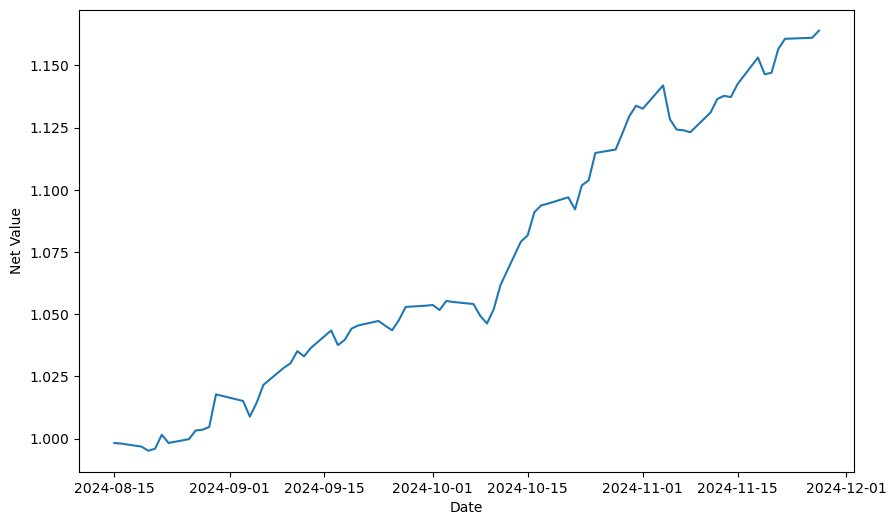

In [206]:
alpha = 'div(ts_corr_10(multiply(Volatility5, Close), multiply(Low, Volatility5)), min(ts_rank_10(Volatility5), ts_rank_5(Channel10)))'

processed_data = preprocess_data(data)
define_window_function()
processed_data = calculate_factor(processed_data, alpha)
net_value = backtest(processed_data)

plt.figure(figsize=(10, 6))
plt.plot(net_value.index, net_value['NetValue'])
plt.xlabel('Date')
plt.ylabel('Net Value')
plt.show()